# <center>PrivacyBench: Federated Learning (CNN)</center>

## Evaluating Federated Learning with CNN

As part of the PrivacyBench benchmarking suite, this notebook implements Federated Learning (FL) using a Convolutional Neural Network (CNN) to evaluate how privacy-preserving decentralization impacts model utility, training efficiency, and energy consumption.

--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr,wandb

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0
wandb: 0.19.11



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.config import ExperimentName
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.paths import RAY_LOG_DIR
from src.local_utility import load_yaml_config, get_weights, set_device, prepare_FL_dataset
from src.tracker import reset_base_memory_csv

------

In [3]:
## Replace with appropritate values

data_name_ = "alzheimer" #"skin_lesions" #
base_type_ = "cnn"
num_labels_ = 4 #Alzheimer-4 & skin_lesions-8 classlabels
exp_name_ = "FL"
experiment_name_ = ExperimentName.FL_CNN

In [4]:
DEVICE = set_device()
reset_base_memory_csv()

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name = exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

------

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name = exp_name_, data_name=data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn)

In [6]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-18 15:36:52,181	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-18 15:36:52,701	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-18 15:36:53,371	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_2c90c9740f7c1021.zip' (25.96MiB) to Ray cluster...
2025-05-18 15:36:53,450	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_2c90c9740f7c1021.zip'.
05/18/2025 15:36:54:DEBUG:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=1, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 15:36:54] Multiple instances of codecarbon are allowed to run at the same time.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This pr

(ClientAppActor pid=103666) 
(ClientAppActor pid=103666) 🔎 Tracker: FL (CNN)
(ClientAppActor pid=103666) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/alzheimer/FL_CNN/client_emissions.csv
(ClientAppActor pid=103666) ⏱️ Total training time: 1 minutes 0 seconds
(ClientAppActor pid=103667) 


(ClientAppActor pid=103666) Seed set to 42
(ClientAppActor pid=103666) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=103666) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=103666)   self.pid = os.fork()
(raylet) [2025-05-18 15:38:13,354 E 101756 101790] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-18_15-36-49_956060_101483 is over 95% full, available space: 2612170752; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-18 15:38:23,364 E 101756 101790] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-18_15-36-49_956060_101483 is over 95% full, available space: 2612162560; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-18 15:38:33,374 E 101756 101790] (raylet) file_system_moni

(ClientAppActor pid=103666) 
(ClientAppActor pid=103666) 🔎 Tracker: FL (CNN) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=103666) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/alzheimer/FL_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=103666) ⏱️ Total training time: 0 minutes 57 seconds [repeated 2x across cluster]


/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=101483) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/emeka/.netrc
wandb: Currently logged in as: emyrs to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `

/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=101483) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-18 15:39:13,411 E 101756 101790] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-18_15-36-49_956060_101483 is over 95% full, available space: 2611974144; capacity: 52589998080. Object creation will fail if spilling is required.



 ___________________________________________________________________________________________________
ExperimentName.FL_CNN Model Final Evaluation 

Test Accuracy: 81.09% | Precision: 0.82 | Recall: 0.81 | F1-Score: 0.81 | ROC-AUC: 0.94 | MCC: 0.70
 


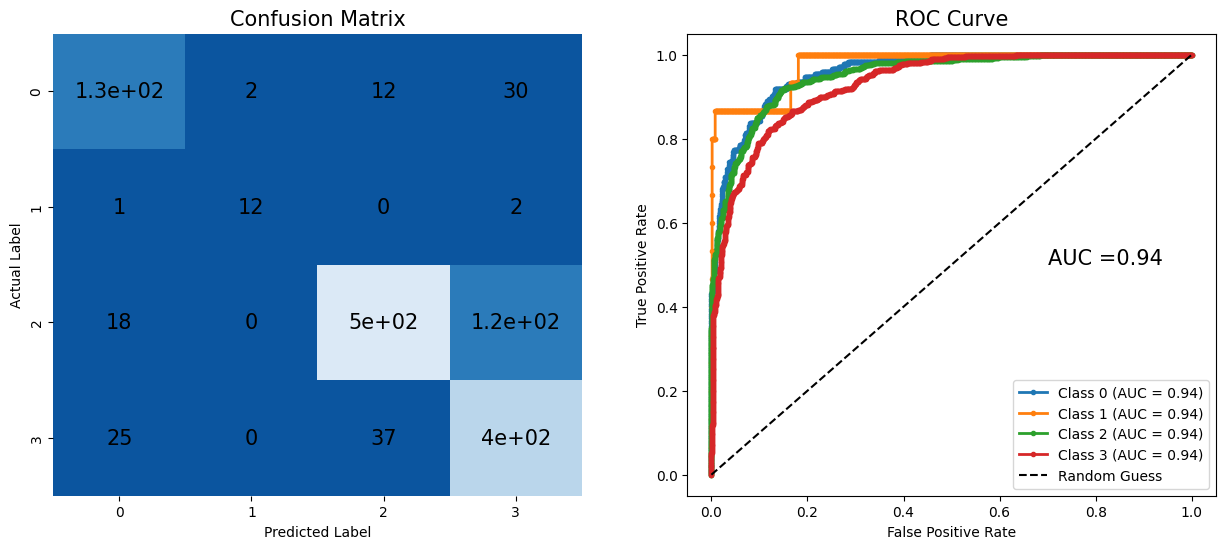


 ___________________________________________________________________________________________________
ExperimentName.FL_CNN--alzheimer Model Classification Report
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       172
           1       0.86      0.80      0.83        15
           2       0.91      0.79      0.85       634
           3       0.73      0.86      0.79       459

    accuracy                           0.81      1280
   macro avg       0.81      0.80      0.80      1280
weighted avg       0.82      0.81      0.81      1280

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 181.13 sec
✅ Total Energy: 0.00730 kWh
🌍 Total CO₂ Emitted: 0.00314 kg
🧠 Peak CPU RAM: 0.0005 GB
🖥️ Peak GPU VRAM: 0.5974 GB

 ___________________________________________________________________________________________________


Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (1, 0.4636342406272888, {'accuracy': 0.8109375}, 137.328367696)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=103666) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=103666) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=103666)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures


🕒 Total Time: 2 min 27 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()

-----